# Homework: Titanic survival dataset exploration

Your goal is to fill #TODO places with your code and answer questions  

Here are some features that can help you determine who survived in Titanic.  
Our quality metric - area under the roc curve

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

SEED = 1337
# !!you should use that seed in all models which accepts random_state

In [284]:
df = pd.read_csv('train.csv', index_col=0)
# df.head()

## fill missing values

In [285]:
# TODO 1:
# encode Sex column
# hint: use LabelEncoder

le = preprocessing.LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])


In [286]:
# print columns with missing values
for name in df.columns:
    print(name, np.sum(pd.isnull(df[name])))

Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


In [287]:
df['Embarked'].mode()

0    S
dtype: object

In [288]:
# Replace missing values with "unkown"
df.loc[df.Cabin.isnull(), 'Cabin'] = 'unknown'

# fill Fare with median value
df.loc[ np.isnan(df['Fare']), 'Fare'] = df['Fare'].median()

# TODO 2
# Replace missing values in Embarked column with most common port
# hint: use Series.mode method

df.loc[ df.Embarked.isnull(), 'Embarked' ] = df['Embarked'].mode()[0]

In [289]:
# TODO 3
# train Random Forest regression model to fill missing values in Age column
# use  100 estimators, set oob_score in True, other params by default
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

age_columns = ['Age', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 
       'Fare', 'Embarked']

age_df = df[age_columns]

age_df['Embarked'] = preprocessing.LabelEncoder().fit_transform(age_df['Embarked'])
train_df = age_df.loc[age_df.Age.notnull()]
test_df = age_df.loc[age_df.Age.isnull()]
print('train age', train_df.shape[0])
print('test age', test_df.shape[0])

model_forest= RandomForestRegressor(random_state=SEED, oob_score=True)
model_forest.fit(train_df.iloc[:,1:], train_df.Age)
df.loc[df.Age.isnull(), 'Age'] = model_forest.predict(test_df.iloc[:,1:]) 

train age 714
test age 177


/Users/Valeriya/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


### Question 1: what is the oob_score of trained model?

In [291]:
model_forest.oob_score_

0.070730684054700732

## feature transformation

In [292]:
# TODO 4
# Create a dataframe of dummy variables for each distinct value of Embarked
# hint: use DataFrame.get_dummies method

# Rename the columns from 'S', 'C', 'Q' to 'Embarked_S', 'Embarked_C', 'Embarked_Q'
# hint: use pandas.rename method

# Add the new dummy variables back to the original data set
# hint: use pandas.concat method

df_dumm = pd.get_dummies(df['Embarked'])
ren = df_dumm.rename(columns={'S':'Embarked_S', 'C':'Embarked_C', 'Q':'Embarked_Q'})
df = pd.concat([df,ren], axis=1)


df['Embarked'] = preprocessing.LabelEncoder().fit_transform(df['Embarked'])
 

In [293]:
import re

In [294]:
# TODO 5

# create feature for the alphabetical part of the cabin number
# hint: use re module
 
# convert the distinct cabin letters with incremental integer values
# hint: use pandas.factorize method

df['CabinLetter'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").findall(x)[0])
df['CabinLetter'] = pd.factorize(df['CabinLetter'])[0]



In [295]:
df['Cabin'] = preprocessing.LabelEncoder().fit_transform(df['Cabin'])

In [296]:
# TODO 6

# Divide all fares into quartiles
# hint: use pandas.qcut

# create dummies from the result and add tham to dataset

df['Fare_quart'] = pd.qcut(df['Fare'], 4)

df_dumm = pd.get_dummies(df['Fare_quart'])
df = pd.concat([df,df_dumm], axis=1)


In [297]:
df = df.drop(['Name', 'Ticket', 'Fare_quart'], axis=1)
df.shape

(891, 17)

In [298]:
# TODO 7
# make dimension reduction with PCA, leave enough components to explain 98% variance of the data, 
# other params by default. Project dataset on these components
# Of course, you should not project your target variable

from sklearn.decomposition import PCA
for ncomp in range(1, 10):
    pca = PCA(n_components=ncomp)
    pca.fit(df.loc[:, df.columns != 'Survived'])

    if sum(pca.explained_variance_ratio_) > 0.98:
        print(ncomp, sum(pca.explained_variance_ratio_))
        break

3 0.998699141689


In [299]:
X_pca = PCA(n_components=3).fit_transform(df.loc[:, df.columns != 'Survived'])

### Question 2: how many components are in PCA?

## Answer: 3

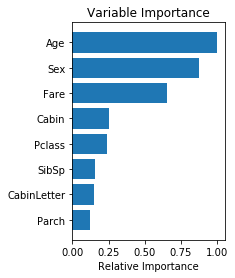

In [300]:
# TODO 8
# plot feature importances from Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


X = df.drop('Survived', axis=1)
y = df.Survived.values
features_list = X.columns
X = X.as_matrix()
 
clf = RandomForestClassifier(n_estimators= 5000)
clf.fit(X, y)
# Train Random Forest Classifier on datasert with 5000 trees, other params by default
# get feature importances from model

feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = feature_importance / feature_importance.max()
 
# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value


fi_threshold = 0.10




# Get the indexes of all features over the importance threshold

important_idx = [i for i, x in enumerate(feature_importance) if x > fi_threshold]
 
# Create a list of all the feature names above the importance threshold



important_features = features_list[important_idx]
 
# Get the sorted indexes of important features

# 
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
 

pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()
 
# Remove non-important features from the feature set


In [301]:
X = df.drop([col for col in list(df.columns) if col not in list(important_features)], axis=1)

### Question 3: What are 4 top most important features?##

## Age, Sex, Fare, Cabin

In [302]:
# stack features

X = np.hstack([X, X_pca])
X.shape

(891, 11)

In [303]:
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import train_test_split

In [305]:
# TODO 9 
# plot learning curves for Random Forest Model (for train and test)
# hint: look at sklearn.learning_curve module. Look at the docs
# use Random Forest with 500 trees, 10-fold cross-validation for roc_auc scoring.
# 
import matplotlib.pyplot as plt
train_sizes = np.linspace(0.1, 1., 10)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=train_sizes, SEED=SEED):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes,train_scores,test_scores = learning_curve(estimator,X, y,
                                                                   cv=cv, n_jobs=n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes,train_scores_mean,'o-',color='r', label='training score')
    plt.plot(train_sizes,test_scores_mean,'o-',color='g', label='testing score')
    plt.legend(loc='best')
    return plt


<module 'matplotlib.pyplot' from '/Users/Valeriya/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

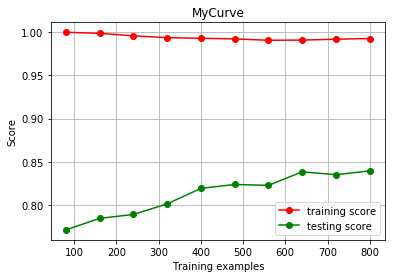

In [324]:
plot_learning_curve(title = 'MyCurve', estimator=RandomForestClassifier(500, random_state=SEED), X=X, y=df.Survived, train_sizes=train_sizes, cv=10)

In [ ]:
# TODO 10
# plot roc auc curve for Random Forest for test dataset
# hint: use roc_curve and auc functions from sklearn.metrics
# use Random Forest with 5000 trees
# use test_size=0.25

In [319]:
clf_10 = RandomForestClassifier(n_estimators=5000, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, df.Survived, test_size = 0.25, random_state=SEED)
clf_10.fit(X_train, y_train)


# from sklearn import metrics
# metrics.roc_curve()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

In [320]:
from sklearn import metrics
predicted = clf_10.predict(X_test)
# metrics.roc_curve()

In [321]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

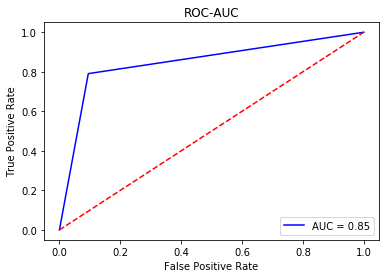

In [322]:
plt.title('ROC-AUC')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Question 4: What is the roc auc score on test dataset ? 

In [323]:
metrics.roc_auc_score(y_test, predicted)

0.84790358173484981